# Simulación

## Método para la selección de mapas

### General

In [292]:
import numpy as np
import random
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt


map_types = {
    "control": ["Busan", "Nepal", "Ilios", "Oasis", "Lijian Tower", "Antarctic Peninsula"],
    "push": ["Esperanca", "Colosseo", "New Queen Street"],
    "escort": ["Circuit Royale", "Dorado", "Route 66", "JunkerTown", "Rialto", "Havana", "Watchpoint Gibraltar", "Shambali Monastery"],
    "hybrid": ["Blizzard World", "Numbani", "Hollywood", "Eichenwalde", "Kings Row", "Midtown", "Paraiso"]
}

map_order = ["control", "hybrid", "push", "escort", "control"]
team_name = 'Vancouver Titans'

## Generador de Encuentros

In [293]:
def getMatches():
    df = pd.read_csv('Team Comp vs Opp Comp_the big cheese_data.csv')
    df = df[df["Season"] > 2022]
    team_names = set(df["team_name"])
    # teams_matches = list(combinations(team_names,r=2))
    titans_matches = [(team_name, i) for i in team_names if i != team_name]
    
    return titans_matches

## Generador de Probabilidades

In [294]:
def getWinrateStats(team):
    # Read data
    dfOW = pd.read_csv('Team Comp vs Opp Comp_the big cheese_data.csv')
    dfOW.replace('Win', 1, inplace=True)
    dfOW.replace('Loss', 0, inplace=True)
    dfOW.replace('Draw', 0.5, inplace=True)
    dfOW = dfOW[~dfOW['map_name'].isin(['Hanamura', 'Paris', 'Horizon Lunar Colony', 'Temple of Anubis', 'Volskaya Industries'])]
    dfOW['Times'] = 1
    
    # Make dictionary
    teamNames = dfOW['team_name'].unique()
    mapNames = dfOW['map_name'].unique()
    mapNames = np.setdiff1d(mapNames, ['Hanamura', 'Paris', 'Horizon Lunar Colony', 'Temple of Anubis', 'Volskaya Industries'])
    
    # Get wins and times played
    dfOW.rename(columns={'opponent (the big cheese)': 'opponent_name'}, inplace=True)
    
    stats1 = dfOW.groupby(['team_name', 'opponent_name','map_name'])['Result'].sum().reset_index().rename(columns = {'0': 'frecuencia'})
    times1 = dfOW.groupby(['team_name', 'opponent_name', 'map_name'])['Times'].sum().reset_index().rename(columns = {'0': 'frecuencia'})
    
    # Get percentages
    stats = pd.merge(stats1,times1, on = ['team_name','opponent_name', 'map_name'])
    
    stats['WinRate'] = stats['Result']/stats['Times']
    
    return stats.loc[stats['team_name'] == team]

In [295]:
winrate_stats = getWinrateStats(team_name)
matches = getMatches()

### Funcion para generar las probabilidades por match basado en el winrate


In [296]:
def getProbsByMatch(opponents, mapType):
    # Devuelve la informacion de los oponentes segun el tipo de mapa que se solicita
    teamName, opponentName = opponents
    info_matches = winrate_stats.loc[
        (winrate_stats['team_name'] == teamName) & (winrate_stats['opponent_name'] == opponentName) & (
            winrate_stats['map_name'].isin(map_types[mapType]))].reset_index()

    # Lista de todos los mapas posibles
    all_maps = map_types[mapType]

    # Crear un diccionario de winrates por mapa y actualizar el diccionario con los winrates conocidos (ACA LE COLOQUE EL PROMEDIO DE SUS WINRATES A LOS DATOS QUE NO EXISTEN, ASI QUE SI
    # USAMOS SOLO LOS QUE SE TIENE INFO Y DESCARTAMOS A LOS OTROS PONELE 0, O SI Q UERES QUE SEA 50/50 PONELE 0.5)
    average_winrate = info_matches['WinRate'].mean()
    if np.isnan(average_winrate): average_winrate = 0.5
    winrate_dict = {map_name: average_winrate for map_name in all_maps}

    for m in range(len(info_matches)):
        map_name = info_matches['map_name'][m]
        winrate_dict[map_name] = info_matches['WinRate'][m]

    # Elevar a la n los WinRates para aumentar la diferencia
    squared_winrates = {map_name: winrate ** 4 for map_name, winrate in winrate_dict.items()}

    # Normalizar los winrates al cuadrado para que sumen 1
    total_squared_winrate = sum(squared_winrates.values())
    normalized_squared_winrates = {map_name: squared_winrate / total_squared_winrate for map_name, squared_winrate in
                                   squared_winrates.items()}

    # Crear una lista de probabilidades basada en los winrates normalizados al cuadrado
    probabilities = [normalized_squared_winrates[map_name] for map_name in all_maps]

    return all_maps, probabilities


#CASO EJEMPLO
maps, res = getProbsByMatch(('Vancouver Titans', 'Florida Mayhem'), 'control')
print(res, sum(res))


[0.6358468199554476, 0.05628423459205381, 0.009306815565044124, 0.09818620047331793, 0.10018796470706827, 0.10018796470706827] 0.9999999999999999


### Funcion para obtener mapas basado en su mejor prob con multinomial

In [297]:

### Funcion para obtener mapas basado en su mejor prob con multinomial
def getMaps(match):
    selected_maps = []
    rep = False
    for map_type in map_order:
        maps_of_type = map_types[map_type]

        # Filtra los mapas disponibles para este tipo
        available_maps = [map for map in maps_of_type if map not in selected_maps]

        # Asegurémonos de que queden mapas disponibles en este tipo
        if not available_maps:
            continue

        # Calcula las probabilidades para la distribución multinomial
        maps, probabilities = getProbsByMatch(match, map_type)

        # Selecciona un mapa utilizando la distribución multinomial
        if np.isnan(probabilities).any():
            print(match, available_maps, maps, probabilities)
        selected_map = np.random.choice(maps, p=probabilities)
        while True:
            if selected_map not in available_maps:
                selected_map = np.random.choice(maps, p=probabilities)
            else:
                break

        selected_maps.append(selected_map)

    return selected_maps


In [298]:

# Verificar que funciona
data = []
for t in range(1000):
    v = getMaps(('Vancouver Titans', 'Florida Mayhem'))
    data.append(v)


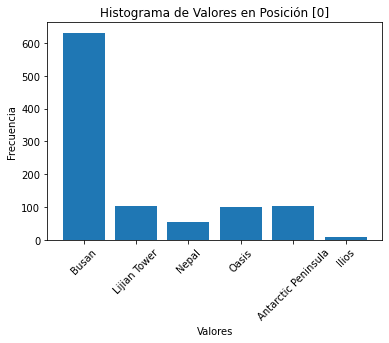

Solo recordando que los valores de probabilidad entre Vancouver y Florida son estos
[Busan, Nepal, Ilios, Oasis, Lijian Tower, Antarctic Peninsula]
[0.6358468199554476, 0.05628423459205381, 0.009306815565044124, 0.09818620047331793, 0.10018796470706827, 0.10018796470706827]


In [299]:
# Extraer los valores en la posición [0]
values = [row[0] for row in data]

# Contar la frecuencia de cada valor
value_counts = {}
for value in values:
    if value in value_counts:
        value_counts[value] += 1
    else:
        value_counts[value] = 1

# Crear el histograma
plt.bar(value_counts.keys(), value_counts.values())
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma de Valores en Posición [0]')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.show()
print("Solo recordando que los valores de probabilidad entre Vancouver y Florida son estos")
print("[Busan, Nepal, Ilios, Oasis, Lijian Tower, Antarctic Peninsula]")
print(
    "[0.6358468199554476, 0.05628423459205381, 0.009306815565044124, 0.09818620047331793, 0.10018796470706827, 0.10018796470706827]")
## Simulación de Encuentros

## Simulación encuentros

In [300]:
# Resultados por mapa
res_maps = pd.DataFrame(columns=['Team', 'Opponent', 'Map', 'Result'])
# Resultados por match
res_matches = pd.DataFrame(columns=['Team', 'Opponent', 'Result', 'Points'])

for match in matches:
    # Mapas que se jugarán en el match actual
    maps = getMaps(match)
    # Puntos por cada mapa jugado
    maps_result = []
    
    for match_map in maps:
        # Selección del winrate para un oponente y un mapa específico
        winrate_s = winrate_stats.loc[(winrate_stats['team_name'] == team_name) & (winrate_stats['opponent_name'] == match[1]) & (winrate_stats['map_name'] == match_map), 'WinRate']
        
        # En el caso de no haber jugado contra el equipo se asigna una probabilidad de victoria de 50%
        if len(winrate_s) == 0:
            winrate = 0.5
        else:
            winrate = winrate_s.values[0]
        
        # Resultados para cada match
        results = []
        # Número de iteraciones para simular cada juego
        iters = 1000
        
        # Simulación de mapa
        for i in range(iters):
            random_number = random.random()
            # Si el número aleatorio es menor al winrate el mapa se toma como ganado en la simulación (se agrega un 1 a la lista)
            results.append(1 if random_number <= winrate else 0)
        
        # Si en los resultados de la simulación el mapa se ganó más de la mitad de las veces se toma como que el mapa fue ganado
        map_result = 'Won' if sum(results) / iters > 0.5 else 'Lost'
        temp_df = pd.DataFrame([{'Team': match[0], 'Opponent': match[1], 'Map': match_map, 'Result': map_result}])
        res_maps = pd.concat([res_maps, temp_df])
        
        # Por cada mapa ganado se suma un punto y por cada mapa perdido se resta un punto
        maps_result.append(1 if map_result == 'Won' else -1)
        
        # Al ganar o perder 3 mapas se detiene la simulación y pasa al siguiente match
        if maps_result.count(1) == 3 or maps_result.count(-1) == 3:
            break
        
    temp_df2 = pd.DataFrame([{'Team': match[0], 'Opponent': match[1], 'Result': 'Won' if maps_result.count(1) == 3 else 'Lost', 'Points': sum(maps_result)}])
    res_matches = pd.concat([res_matches, temp_df2])
res_titans = res_matches
res_maps

,Team,Opponent,Map,Result
0,Vancouver Titans,Shanghai Dragons,Nepal,Lost
0,Vancouver Titans,Shanghai Dragons,Numbani,Lost
0,Vancouver Titans,Shanghai Dragons,Esperanca,Won
0,Vancouver Titans,Shanghai Dragons,Route 66,Won
0,Vancouver Titans,Shanghai Dragons,Ilios,Lost
...,...,...,...,...
0,Vancouver Titans,Dallas Fuel,Oasis,Won
0,Vancouver Titans,Seoul Infernal,Busan,Lost
0,Vancouver Titans,Seoul Infernal,Eichenwalde,Lost
0,Vancouver Titans,Seoul Infernal,New Queen Street,Won


In [301]:

res_maps.to_csv('mapsTitans.csv', mode='a', index=False, header=True)
res_titans.to_csv('resTitans.csv', mode='a', index=False, header=True)
res_matches

,Team,Opponent,Result,Points
0,Vancouver Titans,Shanghai Dragons,Lost,-1
0,Vancouver Titans,Hangzhou Spark,Lost,-1
0,Vancouver Titans,Dreamers,Lost,-2
0,Vancouver Titans,Los Angeles Valiant,Won,2
0,Vancouver Titans,Saints,Won,1
0,Vancouver Titans,Seoul Dynasty,Won,1
0,Vancouver Titans,Washington Justice,Lost,-2
0,Vancouver Titans,Trick Room,Won,3
0,Vancouver Titans,Atlanta Reign,Won,2
0,Vancouver Titans,Vegas Eternal,Won,3


In [302]:
sum(res_matches['Points'])

14

### Simulación del resto de partidos
#### Selección de mapas aleatorias para el resto de partidos

In [303]:
def getRandomMaps():
    map_types = {
        "control": ["Busan", "Nepal", "Ilios", "Oasis", "Lijian Tower", "Antartic Peninsula"],
        "push": ["Esperanca", "Colosseo", "New Queen Street"],
        "escort": ["Circuit Royale", "Dorado", "Route 66", "JunkerTown", "Rialto", "Havana", "Watchpoint Gibraltar", "Shambali Monastery"],
        "hybrid": ["Blizzard World", "Numbani", "Hollywood", "Eichenwalde", "Kings Row", "Midtown", "Paraiso"]
    }

    map_order = ["control", "hybrid", "push", "escort", "control"]
    selected_maps = []

    # Elegir el primer mapa aleatoriamente
    first_map_type = "control"
    selected_maps.append(random.choice(map_types[first_map_type]))

    # Eliminar el mapa seleccionado del tipo para el último mapa
    map_types[first_map_type].remove(selected_maps[0])
    map_order.remove(map_order[0])

    # Calcular las probabilidades para la distribución multinomial
    probabilities = [len(map_types[map_type]) for map_type in map_order]

    # Generar una selección de mapas utilizando la distribución multinomial
    selected_indices = np.random.multinomial(1, probabilities / np.sum(probabilities), size=1)[0]

    # Seleccionar un mapa aleatorio del tipo seleccionado para cada índice
    for selected_index, map_type in zip(selected_indices, map_order):
        selected_map = map_types[map_type][selected_index]
        selected_maps.append(selected_map)

    return selected_maps


In [304]:
def getAllMatches():
    df = pd.read_csv('Team Comp vs Opp Comp_the big cheese_data.csv')
    df = df[df["Season"] > 2022]
    df = df[~df['team_name'].isin(['Vancouver Titans'])]
    team_names = set(df["team_name"])
    teams_matches = list(combinations(team_names,r=2))
    # titans_matches = [(team_name, i) for i in team_names if i != team_name]

    return teams_matches


In [305]:

matches = getAllMatches()
# Resultados por mapa
res_maps = pd.DataFrame(columns=['Team', 'Opponent', 'Map', 'Result'])
# Resultados por match
res_matches = res_titans

for match in matches:
    team_name = match[0]
    winrate_stats = getWinrateStats(team_name)

    # Mapas que se jugarán en el match actual
    maps = getRandomMaps()
    # Puntos por cada mapa jugado
    maps_result = []

    for match_map in maps:
        # Selección del winrate para un oponente y un mapa específico
        winrate_s = winrate_stats.loc[(winrate_stats['team_name'] == team_name) & (winrate_stats['opponent_name'] == match[1]) & (winrate_stats['map_name'] == match_map), 'WinRate']

        # En el caso de no haber jugado contra el equipo se asigna una probabilidad de victoria de 50%
        if len(winrate_s) == 0:
            winrate = 0.5
        else:
            winrate = winrate_s.values[0]

        # Resultados para cada match
        results = []
        # Número de iteraciones para simular cada juego
        iters = 1000

        # Simulación de mapa
        for i in range(iters):
            random_number = random.random()
            # Si el número aleatorio es menor al winrate el mapa se toma como ganado en la simulación (se agrega un 1 a la lista)
            results.append(1 if random_number <= winrate else 0)

        # Si en los resultados de la simulación el mapa se ganó más de la mitad de las veces se toma como que el mapa fue ganado
        map_result = 'Won' if sum(results) / iters > 0.5 else 'Lost'
        temp_df = pd.DataFrame([{'Team': match[0], 'Opponent': match[1], 'Map': match_map, 'Result': map_result}])
        res_maps = pd.concat([res_maps, temp_df])

        # Por cada mapa ganado se suma un punto y por cada mapa perdido se resta un punto
        maps_result.append(1 if map_result == 'Won' else -1)

        # Al ganar o perder 3 mapas se detiene la simulación y pasa al siguiente match
        if maps_result.count(1) == 3 or maps_result.count(-1) == 3:
            break

    temp_df2 = pd.DataFrame([{'Team': match[0], 'Opponent': match[1], 'Result': 'Won' if maps_result.count(1) == 3 else 'Lost', 'Points': sum(maps_result)}])
    res_matches = pd.concat([res_matches, temp_df2])

res_maps


,Team,Opponent,Map,Result
0,Shanghai Dragons,Hangzhou Spark,Oasis,Won
0,Shanghai Dragons,Hangzhou Spark,Blizzard World,Lost
0,Shanghai Dragons,Hangzhou Spark,Esperanca,Won
0,Shanghai Dragons,Hangzhou Spark,Circuit Royale,Lost
0,Shanghai Dragons,Hangzhou Spark,Nepal,Won
...,...,...,...,...
0,Dallas Fuel,Seoul Infernal,Ilios,Lost
0,Dallas Fuel,Seoul Infernal,Numbani,Won
0,Dallas Fuel,Seoul Infernal,Esperanca,Lost
0,Dallas Fuel,Seoul Infernal,Circuit Royale,Won


In [306]:

results_all = res_matches.groupby(['Team'])['Points'].sum().reset_index().rename(columns = {'0': 'frecuencia'})
results_all

,Team,Points
0,Atlanta Reign,-10
1,Boston Uprising,-11
2,Dallas Fuel,1
3,Dreamers,-15
4,Florida Mayhem,17
5,Guangzhou Charge,4
6,Hangzhou Spark,15
7,Houston Outlaws,-14
8,London Spitfire,-1
9,Los Angeles Gladiators,0


In [307]:
results_all.to_csv('results.csv', mode='a', index=False, header=True)